In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import gget
import tabulate
from sklearn.neighbors import BallTree
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.stats import gmean
import networkx as nx
import sys

# locals
sys.path.append('../')
import utils as ut

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

done


In [3]:
totcells = 0
for key in keys:
    rf = rna[key]
    print(rf.shape)
    
    totcells += rf.shape[0]
    
print(totcells)

(1261, 31053)
(6123, 31053)
(6436, 31053)
13820


In [4]:
# UT = 0.025
UT = 0.02
"""
Ubiquitousness Index (0-1). 
0 indicates the gene is not expressed in any cell cluster and 
1 (maximum) indicates that the gene is expressed in all cell clusters. 
"""

# load gene lists 
pandPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"        
pandf = ut.read_panglaodb(pandPath)

cTypes = [
    'B cells', 
    'Dendritic cells',
    'Macrophages',
    'Monocytes', 
    'NK cells',
    'T cells', 
]

mf = pandf[pandf['cell type'].isin(cTypes)]
print(pd.DataFrame(mf['cell type'].value_counts()))
print()

mf = mf[mf['ubiquitousness index'] < UT]

print(pd.DataFrame(mf['cell type'].value_counts()))
print()

mf.head()


                 count
cell type             
Macrophages        153
Dendritic cells    133
B cells            110
T cells            107
Monocytes          102
NK cells            98

                 count
cell type             
Macrophages         79
Dendritic cells     76
B cells             68
NK cells            68
T cells             50
Monocytes           46



,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse,gene
422,Mm Hs,CD5,B cells,NaN,0.004,CD5 molecule,protein-coding gene,1.0,Mesoderm,Immune system,0.000000,0.000000,0.004153,0.004502,CD5
423,Mm Hs,MS4A1,B cells,Bp35|MS4A2|CD20,0.014,membrane spanning 4-domains A1,protein-coding gene,1.0,Mesoderm,Immune system,0.483871,0.620155,0.011182,0.001566,MS4A1
424,Mm Hs,CR2,B cells,CD21|C3DR,0.001,complement C3d receptor 2,protein-coding gene,1.0,Mesoderm,Immune system,0.048387,0.034884,0.000000,0.000000,CR2
425,Mm Hs,CD22,B cells,SIGLEC-2|SIGLEC2,0.003,CD22 molecule,protein-coding gene,1.0,Mesoderm,Immune system,0.096774,0.127907,0.001278,0.000196,CD22
426,Hs,FCER2,B cells,CLEC4J|CD23|CD23A|FCE2,0.002,Fc fragment of IgE receptor II,protein-coding gene,1.0,Mesoderm,Immune system,0.016129,0.000000,0.001917,0.000000,FCER2


In [5]:
colors = {
    
    "B cells" : '#9e0142',
    "Dendritic cells" : '#e95c47',
    "Macrophages" : '#fdbf6f',
    "Monocytes" : '#ffffbe',
    'NK cells' : '#bfe5a0',
    "T cells" : '#5e4fa2',
}

colors

{'B cells': '#9e0142',
 'Dendritic cells': '#e95c47',
 'Macrophages': '#fdbf6f',
 'Monocytes': '#ffffbe',
 'NK cells': '#bfe5a0',
 'T cells': '#5e4fa2'}

key='ND' ctype='B cells' ingroup.shape=(362, 8) len(markers)=65
key='ND' ctype='Dendritic cells' ingroup.shape=(143, 8) len(markers)=61
key='ND' ctype='Macrophages' ingroup.shape=(359, 8) len(markers)=75
key='ND' ctype='Monocytes' ingroup.shape=(175, 8) len(markers)=32
key='ND' ctype='NK cells' ingroup.shape=(96, 8) len(markers)=57
key='ND' ctype='T cells' ingroup.shape=(93, 8) len(markers)=44
key='HFD8' ctype='B cells' ingroup.shape=(282, 8) len(markers)=65
key='HFD8' ctype='Dendritic cells' ingroup.shape=(1058, 8) len(markers)=61
key='HFD8' ctype='Macrophages' ingroup.shape=(2188, 8) len(markers)=75
key='HFD8' ctype='Monocytes' ingroup.shape=(714, 8) len(markers)=32
key='HFD8' ctype='NK cells' ingroup.shape=(505, 8) len(markers)=57
key='HFD8' ctype='T cells' ingroup.shape=(1298, 8) len(markers)=44
key='HFD14' ctype='B cells' ingroup.shape=(183, 8) len(markers)=65
key='HFD14' ctype='Dendritic cells' ingroup.shape=(882, 8) len(markers)=61
key='HFD14' ctype='Macrophages' ingroup.shape=(

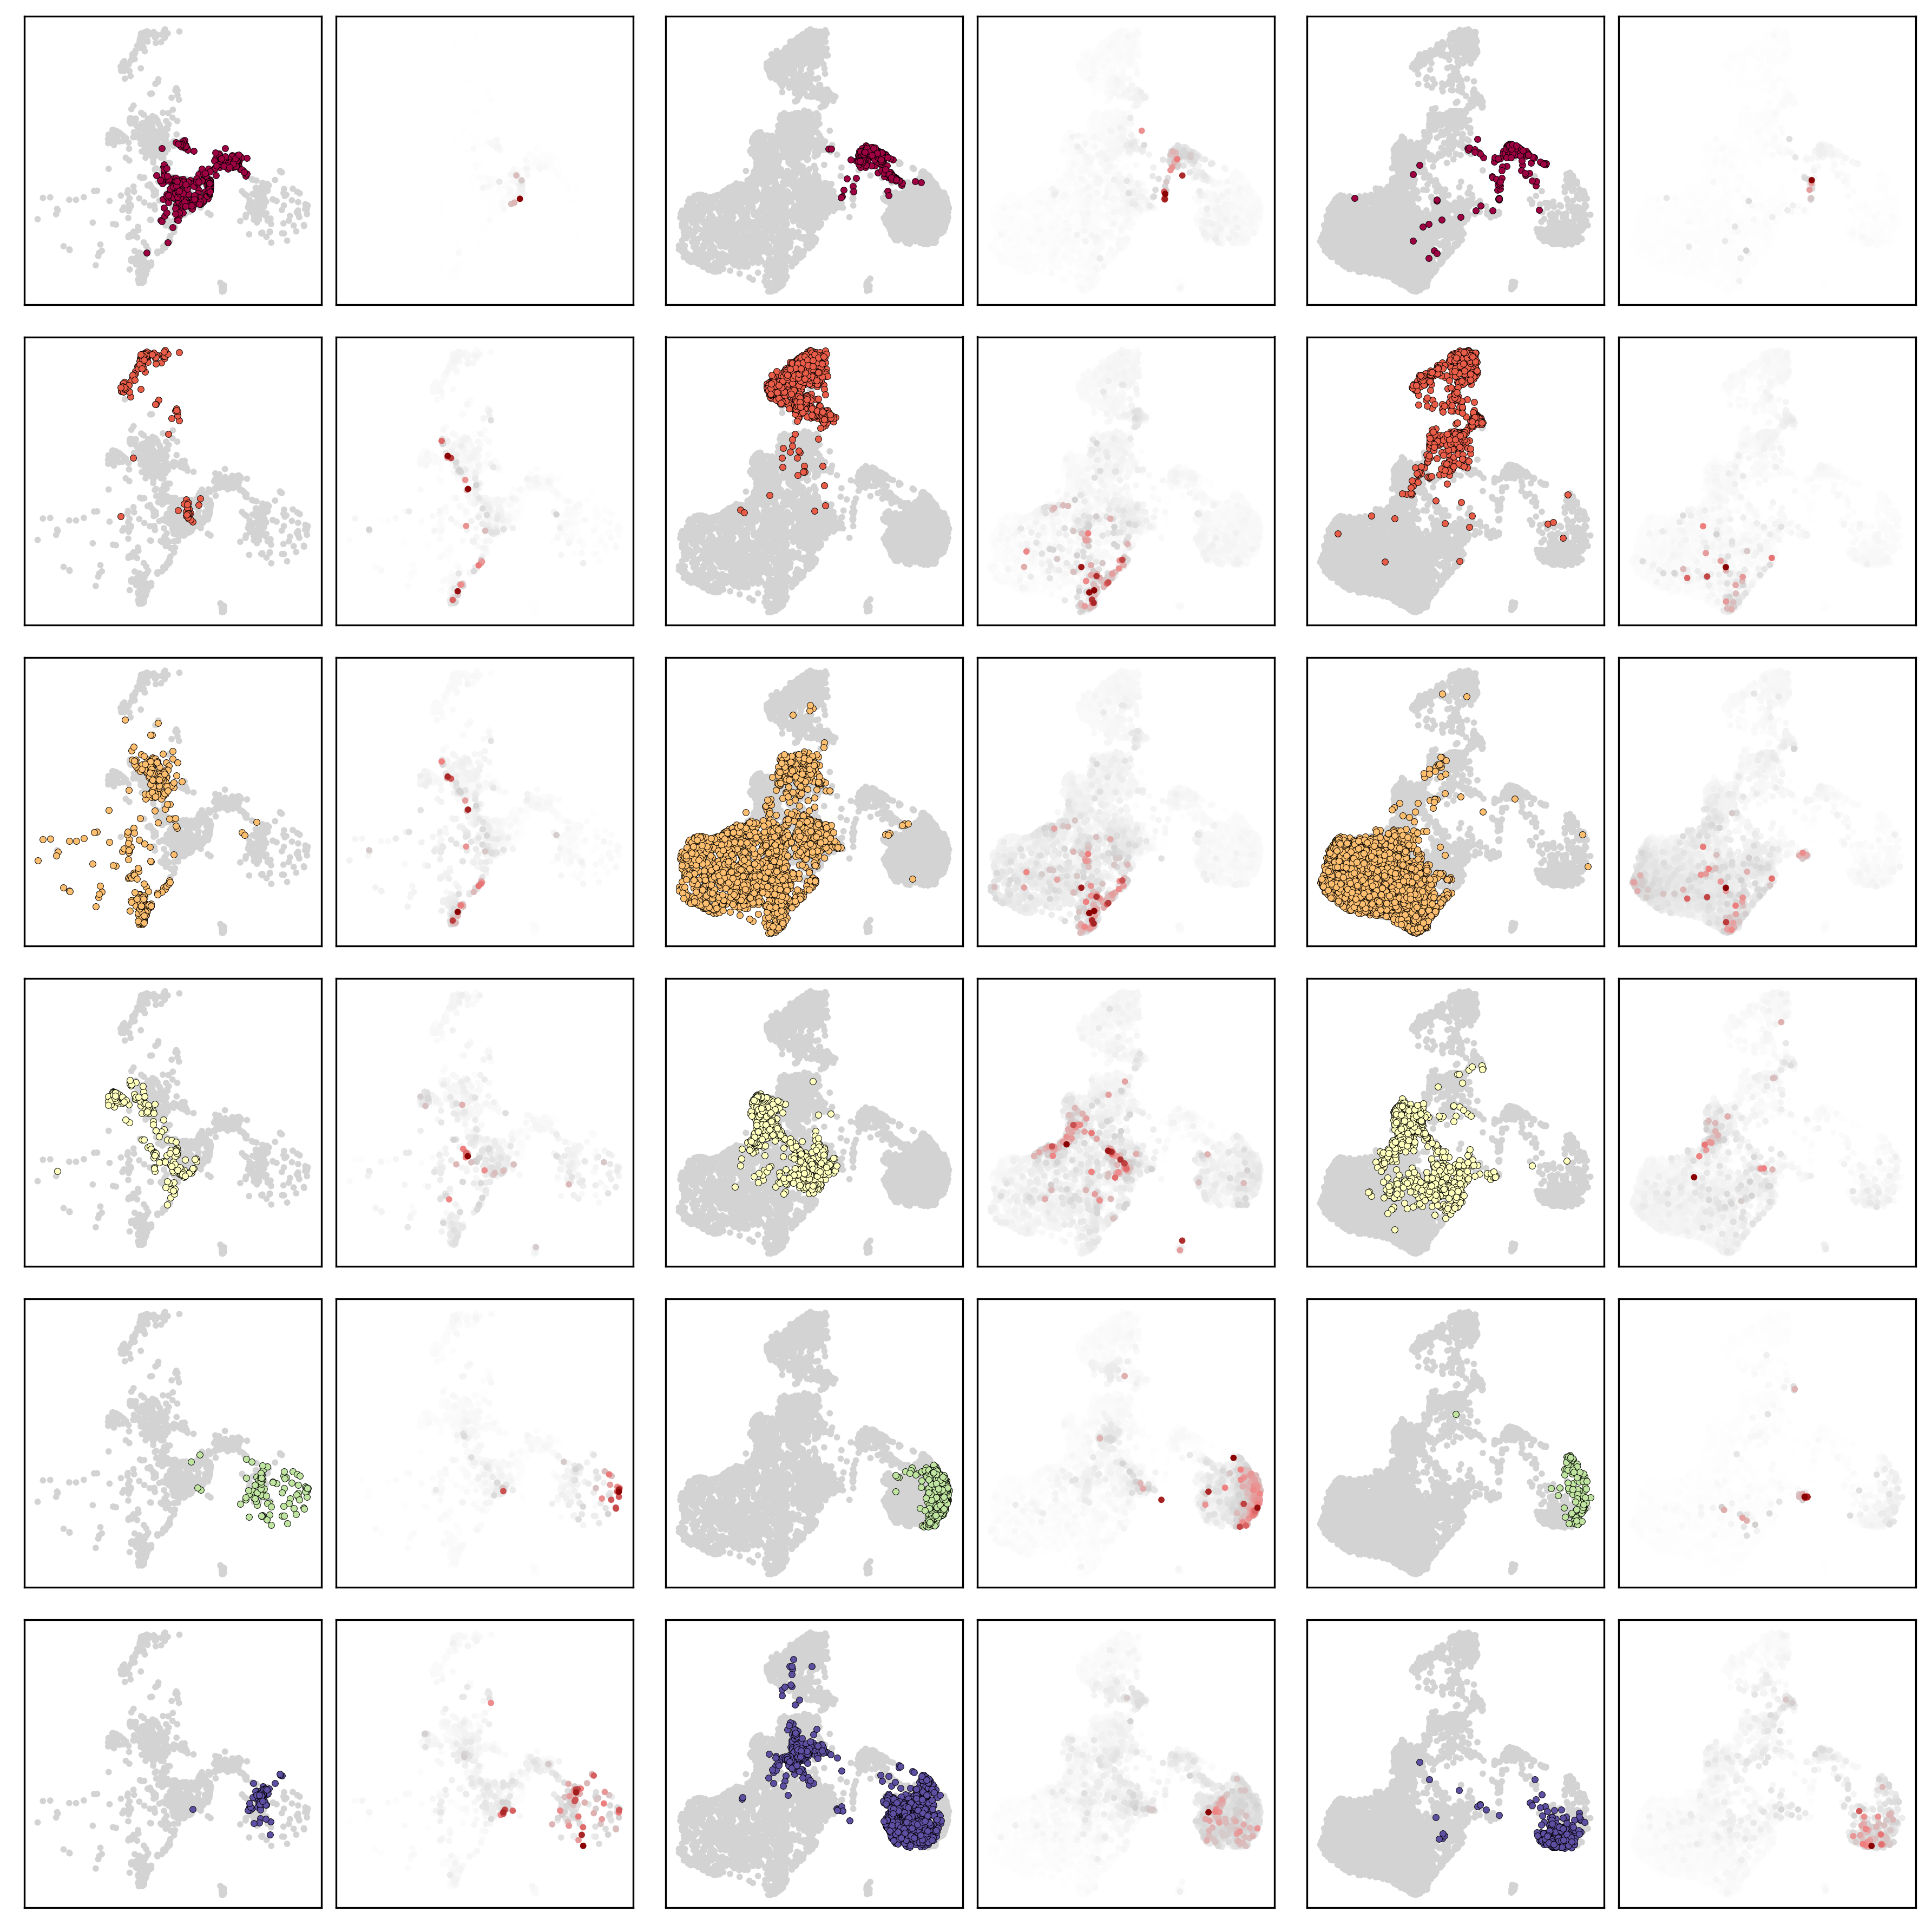

In [20]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 12

mtypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

size = 8

# cmap = plt.cm.get_cmap('viridis', lut=5)
cmColors = ["white", "lightgrey", "lightcoral",'darkred']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cmColors)


res = []

fig, axs =  plt.subplots(6, 3)

for j, key in enumerate(keys):
    
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId').reset_index()
    lf['metatype'] = np.where(lf['cellType'].isin(mtypes), "Macrophages", lf['cellType'])
    
    
    for i, ctype in enumerate(cTypes):
        
        markers = mf[mf['cell type'] == ctype]['gene'].to_list()
        markers = [x for x in markers if x in rf.columns]
        ingroup = lf[lf['metatype'] == ctype]
        outgroup = lf[lf['metatype'] != ctype]

        edf = rf[markers]
        expression = edf.mean(axis=1)

        # format data for saving
        edf = edf.reset_index(drop=False)
        edf = pd.melt(edf, id_vars='cellId')
        edf.columns = ['cellId', 'gene', 'cpm']
        edf['cellType'] = ctype
        edf['cellType'] = ctype
        res.append(edf)
        
    
        # expression = np.log1p(expression)

        
        print(f"{key=} {ctype=} {ingroup.shape=} {len(markers)=}")
            
        sns.scatterplot(data=ingroup, 
                        x='x',
                        y='y',
                        color=colors[ctype],
                        ec='k',
                        s=size,
                        zorder=2,
                        ax=axs[i, j])
        
        sns.scatterplot(data=lf, 
                         x='x',
                         y='y',
                         color="lightgrey",
                         ec='None',
                         s=size,
                         zorder=1,
                         ax=axs[i, j])
        
        axs[i, j].set_ylabel('')
        axs[i, j].set_xlabel('')
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        
        """ Append expression """
        ax_divider = make_axes_locatable(axs[i, j])
        ax2 = ax_divider.append_axes("right", 
                                     size="100%", 
                                     pad=f"5%")
        
        # "z-order" by the expression
        order = np.argsort(expression)
        sns.scatterplot(data=lf.reindex(order), 
                         x='x',
                         y='y',
                         c=np.array(expression)[order],
                         ec='None',
                         cmap=cmap,
                         s=size,
                         zorder=1,
                         ax=ax2)
        
        ax2.set_ylabel('')
        ax2.set_xlabel('')
        ax2.set_yticks([])
        ax2.set_xticks([])
    
plt.tight_layout()


In [21]:
res = pd.concat(res)
res.head()

,cellId,gene,cpm,cellType
0,AAACGAACAGCAGTAG.1,CD5,0.0,B cells
1,AAAGAACGTCTACAGT.1,CD5,0.0,B cells
2,AAAGAACTCCTCGCAT.1,CD5,0.0,B cells
3,AAAGGGCGTTAGGGTG.1,CD5,0.0,B cells
4,AACAAAGAGTATAGGT.1,CD5,0.0,B cells


In [22]:
outdir = '/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/'
fname = "marker_gene_plot.csv"

res.to_csv(f"{outdir}{fname}", index=False)
res.head()

,cellId,gene,cpm,cellType
0,AAACGAACAGCAGTAG.1,CD5,0.0,B cells
1,AAAGAACGTCTACAGT.1,CD5,0.0,B cells
2,AAAGAACTCCTCGCAT.1,CD5,0.0,B cells
3,AAAGGGCGTTAGGGTG.1,CD5,0.0,B cells
4,AACAAAGAGTATAGGT.1,CD5,0.0,B cells


In [ ]:
break

In [ ]:
?ut.makeColorbar

In [ ]:
ut.makeColorbar(cmap, 
                0.3, 2.5, 
                "Expression", 
                "vertical",
                ['Low', 'High'])

In [ ]:
for j, key in enumerate(keys):
    
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId').reset_index()
    lf['metatype'] = np.where(lf['cellType'].isin(mtypes), "Macrophages", lf['cellType'])
    
    
    for i, ctype in enumerate(cTypes):
        print(f"{key=} {ctype=}")
        
        markers = mf[mf['cell type'] == ctype]['gene'].to_list()
        markers = [x for x in markers if x in rf.columns]
        ingroup = lf[lf['metatype'] == ctype]
        outgroup = lf[lf['metatype'] != ctype]
        expression = rf[markers].mean(axis=1)
        expression = np.sqrt(expression)
        
        
    break